<a href="https://colab.research.google.com/github/anshupandey/AI_Agents/blob/main/AAP_C6_LangChain_Chain_reflection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reflection


In the context of LLM agent building, reflection refers to the process of prompting an LLM to observe its past steps (along with potential observations from tools/the environment) to assess the quality of the chosen actions.
This is then used downstream for things like re-planning, search, or evaluation.

![Reflection](https://github.com/anshupandey/AI_Agents/blob/img/reflection.png?raw=1)

This notebook demonstrates a very simple form of reflection in LangGraph.

#### Prerequisites

We will be using a basic agent with a search tool here.

In [1]:
!pip install -q -U langchain-core langchain-community langgraph
!pip install --upgrade --quiet google-cloud-aiplatform requests
!pip install -q -U langchain-google-vertexai wikipedia tavily-python
!pip install -q -U httpx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.3/366.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.4/91.4 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.6/983.6 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 1.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 2.0 MB/s eta 0:00:0

In [2]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [1]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

In [2]:
PROJECT_ID = "jrproject-402905"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

## Generate

For our example, we will create a "5 paragraph essay" generator. First, create the generator:


In [3]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_google_vertexai import ChatVertexAI

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an essay assistant tasked with writing excellent 5-paragraph essays."
            " Generate the best essay possible for the user's request."
            " If the user provides critique, respond with a revised version of your previous attempts.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)


llm = ChatVertexAI(model="gemini-1.5-flash-001")

generate = prompt | llm

In [4]:
essay = ""
request = HumanMessage(
    content="Write an essay on why the little prince is relevant in modern childhood"
)
for chunk in generate.stream({"messages": [request]}):
    print(chunk.content, end="")
    essay += chunk.content

## The Enduring Relevance of the Little Prince in Modern Childhood

Antoine de Saint-Exupéry's "The Little Prince" is a timeless tale that continues to resonate with readers of all ages, particularly children. While the world has changed drastically since its publication in 1943, the story's themes of innocence, wonder, and the search for meaning remain profoundly relevant to the modern child navigating a complex and often overwhelming world. 

The Little Prince's journey across the cosmos, encountering diverse characters and unique planets, mirrors the child's own exploration of the world. Each encounter, from the conceited man

In [9]:
essay

'## The Enduring Relevance of the Little Prince in Modern Childhood\n\nAntoine de Saint-Exupéry\'s "The Little Prince" is a timeless tale that continues to resonate with readers of all ages, particularly children. While the world has changed drastically since its publication in 1943, the story\'s themes of innocence, wonder, and the search for meaning remain profoundly relevant to the modern child navigating a complex and often overwhelming world. \n\nThe Little Prince\'s journey across the cosmos, encountering diverse characters and unique planets, mirrors the child\'s own exploration of the world. Each encounter, from the conceited man'

### Reflect

In [12]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a teacher grading an essay submission. Generate critique and recommendations for the user's submission."
            " Provide detailed recommendations, including requests for length, depth, style, etc.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
llm = ChatVertexAI(model="gemini-1.5-flash-001")
reflect = reflection_prompt | llm

In [18]:
reflection = ""
for chunk in reflect.stream({"messages": [HumanMessage(content=request.content + "\n" + essay)]}):
    print(chunk.content, end="")
    reflection += chunk.content

This is a good start to an essay on the relevance of "The Little Prince" to modern childhood. You've identified some key themes and have begun to connect them to the modern child's experience. However, there are some areas where you can expand and improve your essay. 

Here are some specific recommendations:

**1. Expand on your Introduction:**

* **Hook:** Start with a captivating sentence or two that grabs the reader's attention. For example, you could begin with a statistic about the enduring popularity of "The Little Prince" or a personal anecdote about how the story impacted you as a child.


### Repeat

And... that's all there is too it! You can repeat in a loop for a fixed number of steps, or use an LLM (or other check) to decide when the finished product is good enough.

In [19]:
for chunk in generate.stream(
    {"messages": [request, AIMessage(content=essay), HumanMessage(content=reflection)]}
):
    print(chunk.content, end="")

## The Enduring Relevance of the Little Prince in Modern Childhood

In a world increasingly dominated by technology and fast-paced living, it's easy to forget the simple joys of childhood wonder and imagination. Yet, Antoine de Saint-Exupéry's "The Little Prince," a timeless tale first published in 1943, continues to captivate readers of all ages, particularly children.  Despite the vast changes in the world since its publication, the story's themes of innocence, wonder, and the search for meaning remain profoundly relevant to the modern child navigating a complex and often overwhelming world. 

The Little Prince

## Define graph

Now that we've shown each step in isolation, we can wire it up in a graph.

In [25]:
from typing import List, Sequence

from langgraph.graph import END, MessageGraph, START
import time

async def generation_node(state: Sequence[BaseMessage]):
    return await generate.ainvoke({"messages": state})


async def reflection_node(messages: Sequence[BaseMessage]) -> List[BaseMessage]:
    # Other messages we need to adjust
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    time.sleep(30)
    # First message is the original user request. We hold it the same for all nodes
    translated = [messages[0]] + [
        cls_map[msg.type](content=msg.content) for msg in messages[1:]
    ]
    res = await reflect.ainvoke({"messages": translated})
    # We treat the output of this as human feedback for the generator
    return HumanMessage(content=res.content)


builder = MessageGraph()
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_edge(START, "generate")


def should_continue(state: List[BaseMessage]):
    if len(state) > 6:
        # End after 3 iterations
        return END
    return "reflect"


builder.add_conditional_edges("generate", should_continue)
builder.add_edge("reflect", "generate")
graph = builder.compile()

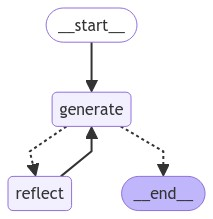

In [26]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [28]:
async for event in graph.astream(
    [
        HumanMessage(
            content="Generate an essay on the topicality of The Little Prince and its message in modern life"
        )
    ],
):
    print(event)
    print("---")

{'generate': AIMessage(content='## The Enduring Relevance of "The Little Prince": A Timeless Tale for Modern Times\n\nAntoine de Saint-Exupéry\'s "The Little Prince," a seemingly simple children\'s story, transcends age and cultural boundaries, resonating with readers of all ages and backgrounds. Its enduring popularity lies in its timeless message, a poignant reflection on the human condition that remains profoundly relevant in our modern world. The story, narrated by a pilot stranded in the Sahara desert, explores themes of love, loss, friendship, and the importance of seeing the world with childlike wonder. \n\nOne of the most striking aspects of "The Little Prince', response_metadata={'is_blocked': False, 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability_label': 'NEGLIGIBLE', 'blocked': False, 'severity': 'HARM_SEVERITY_NEGLIGIBLE'}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability_label': 'NEGLIGIBLE', 'blocked': False, 'severity': 'HARM_SEVERIT

InvalidArgument: 400 Please ensure that multiturn requests alternate between user and model.

In [ ]:
ChatPromptTemplate.from_messages(event[END]).pretty_print()

================================ Human Message =================================

Generate an essay on the topicality of The Little Prince and its message in modern life

================================== Ai Message ==================================

Title: The Enduring Relevance of The Little Prince: A Timeless Message for Modern Life

Introduction:
Antoine de Saint-Exupéry's The Little Prince is a canonical work of literature, beloved by generations since its publication in 1943. The novella has been translated into more than 250 languages and sold over 140 million copies, making it one of the best-selling books of all time. Its enchanting story transcends cultural boundaries and continues to captivate audiences of all ages. The Little Prince's timeless message remains relevant in modern life, offering insightful commentary on themes such as love, loneliness, responsibility, and the superficiality of the adult world. In this essay, we will discuss the topicality of The Little Princ

## Conclusion

Now that you've applied reflection to an LLM agent, I'll note one thing: self-reflection is inherently cyclic: it is much more effective if the reflection step has additional context or feedback (from tool observations, checks, etc.). If, like in the scenario above, the reflection step simply prompts the LLM to reflect on its output, it can still benefit the output quality (since the LLM then has multiple "shots" at getting a good output), but it's less guaranteed.
